In [13]:
from feature_definitions import BOWFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
import os
import pandas as pd
from pprint import pprint

In [14]:
X_train, y_train = [], []
print('Loading training data')
data_dir = '/data/movie_reviews/aclImdb/train/'
for f in os.listdir(os.path.join(data_dir, 'neg')):
    X_train.append(open(os.path.join(data_dir, 'neg', f)).read())
    y_train.append(0)
for f in os.listdir(os.path.join(data_dir, 'pos')):
    X_train.append(open(os.path.join(data_dir, 'pos', f)).read())
    y_train.append(1)

Loading training data


In [15]:
# Build model and train on training data
union_list = []
print ("add Bag of Words features .....")
union_list.append(("tfidf", BOWFeatures()))
pipeline = Pipeline([
        ('union', FeatureUnion(union_list)),
        ('lr', LogisticRegression(solver="liblinear", max_iter = 500,
                                  class_weight="balanced")),
    ])

print("Now doing training on training set and hyperparameter tuning using the validation set...")
print("pipeline:", [name for name, _ in pipeline.steps])

#X_train = pd.DataFrame({'text': X_train})
pipeline.fit(X_train, y_train)

add Bag of Words features .....
Now doing training on training set and hyperparameter tuning using the validation set...
pipeline: ['union', 'lr']


Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('tfidf',
                                                 BOWFeatures(lowercase=True,
                                                             max_df=1.0,
                                                             min_df=5,
                                                             ngram_range=(1, 1),
                                                             norm='l2',
                                                             token_pattern='\\w+',
                                                             tokenizer=None,
                                                             use_idf=True))],
                              transformer_weights=None, verbose=False)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                    fit_intercept=True, interce

In [16]:
X_test, y_test = [], []
print('Loading testing data')
data_dir = '/data/movie_reviews/aclImdb/test/'
for f in os.listdir(os.path.join(data_dir, 'neg')):
    X_test.append(open(os.path.join(data_dir, 'neg', f)).read())
    y_test.append(0)
for f in os.listdir(os.path.join(data_dir, 'pos')):
    X_test.append(open(os.path.join(data_dir, 'pos', f)).read())
    y_test.append(1)

Loading testing data


In [5]:
#X_test = pd.DataFrame({'text': X_test})
pipeline.score(X_test, y_test)

0.8862

In [17]:
tmp = pipeline.predict(X_test)

In [18]:
list(tmp).count(1), list(tmp).count(0)

(12483, 12517)

In [6]:
# split review into sentences and predict the pos probability of each sentence, only select review with more than 20 sentences
from nltk.tokenize import sent_tokenize
X_sents, y_sents = [], []
for x, y in zip(X_test, y_test):
    doc = sent_tokenize(x)
    if len(doc)>=20:
        X_sents.append(doc)
        y_sents.append(y)
print(len(X_sents))

2559


In [7]:
X_flat, X_idx = [], []
for i, doc in enumerate(X_sents):
    X_flat.extend(doc)
    X_idx.extend([i]*len(doc))

In [8]:
#X_flat = pd.DataFrame({'text': X_flat})
X_flat_predicted = pipeline.predict_proba(X_flat)[:, 1]

In [9]:
X_traj = [[] for _ in range(len(X_sents))]
for idx, x_pred in zip(X_idx, X_flat_predicted):
    X_traj[idx].append(x_pred)

In [10]:
# scale the trajectory of each review to same length (20)
import numpy as np
from scipy import interpolate
X_interp = []
for x in X_traj:
    x = np.array(x)
    interp = interpolate.interp1d(np.arange(x.size),x)
    X_interp.append(interp(np.linspace(0,x.size-1, 20)))

In [11]:
# In following cells, I try to plot  review trajectories on 2D space to find the trajectory patterns
pos, neg = [],[]
for label, tsne in zip(y_sents, X_interp):
    if label == 0:
        neg.append(tsne)
    else:
        pos.append(tsne)

In [12]:
from sklearn.manifold import TSNE
tsne_pos = TSNE(n_components=2).fit_transform(pos)
tsne_neg = TSNE(n_components=2).fit_transform(neg)
tsne_all = TSNE(n_components=2).fit_transform(pos+neg)




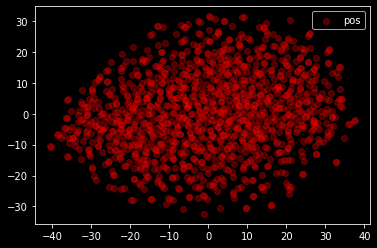

In [13]:
#no clear cluster
import matplotlib.pyplot as plt
pos_plot = list(map(list, zip(*tsne_pos)))
fig, ax = plt.subplots()
ax.scatter(pos_plot[0], pos_plot[1], c="red", label="pos",
               alpha=0.3)
ax.legend()
plt.show()

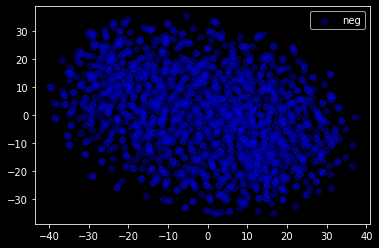

In [14]:
#no clear cluster
import matplotlib.pyplot as plt
neg_plot = list(map(list, zip(*tsne_neg)))
fig, ax = plt.subplots()
ax.scatter(neg_plot[0], neg_plot[1], c="blue", label="neg",
alpha=0.3)
ax.legend()
plt.show()

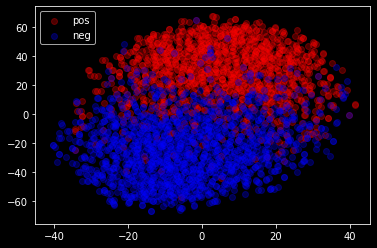

In [15]:
#do have cluster, but it may only because that pos reviews have higher pos probability
import matplotlib.pyplot as plt
pos_plot = list(map(list, zip(*tsne_all[:len(pos)])))
neg_plot = list(map(list, zip(*tsne_all[len(pos):])))
fig, ax = plt.subplots()
ax.scatter(pos_plot[0], pos_plot[1], c="red", label="pos",
               alpha=0.3)
ax.scatter(neg_plot[0], neg_plot[1], c="blue", label="neg",
alpha=0.3)
ax.legend()
plt.show()

In [16]:
#Thus, I move all trajectories to the middle
X_interp = np.array(X_interp)
print((0.5 - X_interp.mean(axis=1, keepdims=True)).shape)
X_shift_interp = X_interp - ( X_interp.mean(axis=1, keepdims=True))
pos, neg = [],[]
for label, tsne in zip(y_sents, X_shift_interp):
    if label == 0:
        neg.append(tsne)
    else:
        pos.append(tsne)

(2559, 1)


In [17]:
from sklearn.manifold import TSNE
tsne_pos = TSNE(n_components=2).fit_transform(pos)
tsne_neg = TSNE(n_components=2).fit_transform(neg)
tsne_all = TSNE(n_components=2).fit_transform(pos+neg)




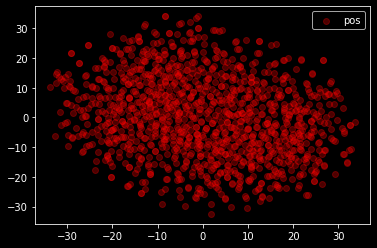

In [18]:
#still no clear cluster
import matplotlib.pyplot as plt
pos_plot = list(map(list, zip(*tsne_pos)))
fig, ax = plt.subplots()
ax.scatter(pos_plot[0], pos_plot[1], c="red", label="pos",
               alpha=0.3)
ax.legend()
plt.show()

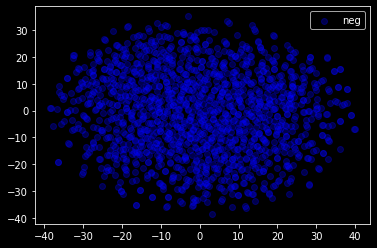

In [19]:
#still no clear cluster
import matplotlib.pyplot as plt
neg_plot = list(map(list, zip(*tsne_neg)))
fig, ax = plt.subplots()
ax.scatter(neg_plot[0], neg_plot[1], c="blue", label="neg",
alpha=0.3)
ax.legend()
plt.show()

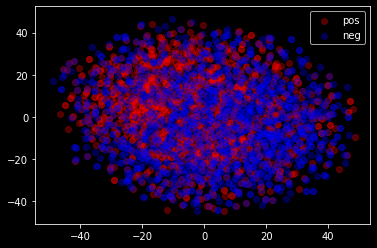

In [20]:
#still no clear cluster, but it looks li pos reviews are concentrated to the lefthand side
import matplotlib.pyplot as plt
pos_plot = list(map(list, zip(*tsne_all[:len(pos)])))
neg_plot = list(map(list, zip(*tsne_all[len(pos):])))
fig, ax = plt.subplots()
ax.scatter(pos_plot[0], pos_plot[1], c="red", label="pos",
               alpha=0.3)
ax.scatter(neg_plot[0], neg_plot[1], c="blue", label="neg",
alpha=0.3)
ax.legend()
plt.show()

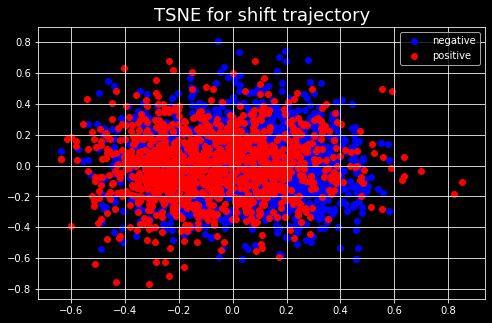

In [45]:
# PCA is more clear that tsne
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
ldaa = PCA(n_components=2)
reduce_all = ldaa.fit_transform(X_shift_interp, y_sents)
plt.figure(figsize=(8,5))
plt.title("TSNE for shift trajectory", fontsize=18)
plt.grid(True)
y = np.array(y_sents)
plt.scatter(reduce_all[y==0,0], reduce_all[y==0,1],label="negative", color="blue")
plt.scatter(reduce_all[y==1,0], reduce_all[y==1,1], label="positive", color="red")
plt.legend()
plt.show()

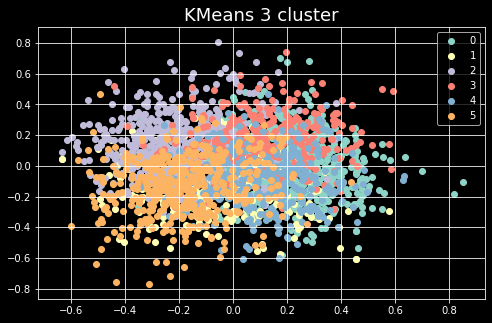

In [53]:
#Cluster all trajectories by AgglomerativeClustering
from sklearn.cluster import KMeans
#dbs = cluster.DBSCAN(eps=0.01,min_samples=5)
#dbs.fit(X_shift_interp)
dbs = cluster.AgglomerativeClustering(linkage='ward', n_clusters=6)
#dbs = cluster.KMeans(n_clusters=5)
dbs.fit(X_shift_interp)
plt.figure(figsize=(8,5))
plt.title("KMeans 3 cluster", fontsize=18)
plt.grid(True)
for i in range(6):
    plt.scatter(reduce_all[dbs.labels_==i,0], reduce_all[dbs.labels_==i,1],label=i)

plt.legend()
plt.show()

(20,)
percent of positive reviews 0.32934131736526945


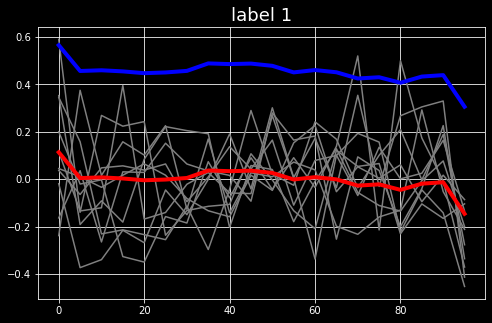

In [47]:
# show the mean of reviewe trajectories in different clusters, please ignore the plot title!
plt.figure(figsize=(8,5))
plt.title("label 1", fontsize=18)
plt.grid(True)
x_coor = np.arange(0, 100, 5)
print(x_coor.shape)
count = 0
for i, label in enumerate(dbs.labels_):
    if label == 1:
        count+=1
        plt.plot(x_coor, X_shift_interp[i],color='gray')
    if count >= 10:
        break
y = np.array(y_sents)
plt.plot(x_coor, X_shift_interp[dbs.labels_==1].mean(axis=0),color='red', linewidth=4)
plt.plot(x_coor, X_interp[dbs.labels_==1].mean(axis=0),color='blue', linewidth=4)
print("percent of positive reviews", sum(y[dbs.labels_==1])/len(y[dbs.labels_==1]))
plt.show()

(20,)
percent of positive reviews 0.8348348348348348


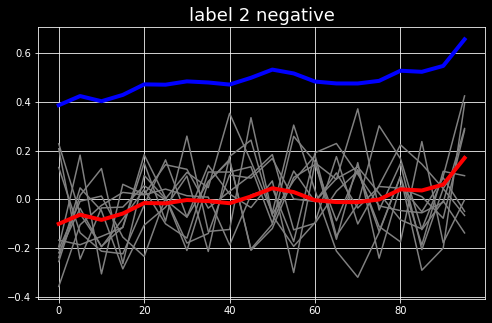

In [48]:
plt.figure(figsize=(8,5))
plt.title("label 2 negative", fontsize=18)
plt.grid(True)
x_coor = np.arange(0, 100, 5)
print(x_coor.shape)
count = 0
for i, label in enumerate(dbs.labels_):
    if label == 2:
        count+=1
        plt.plot(x_coor, X_shift_interp[i],color='gray')
    if count >= 10:
        break
y = np.array(y_sents)
plt.plot(x_coor, X_shift_interp[dbs.labels_==2].mean(axis=0),color='red', linewidth=4)
plt.plot(x_coor, X_interp[dbs.labels_==2].mean(axis=0),color='blue', linewidth=4)
plt.show()
print("percent of positive reviews", sum(y[dbs.labels_==2])/len(y[dbs.labels_==3]))

(20,)
percent of positive reviews 0.5480225988700564


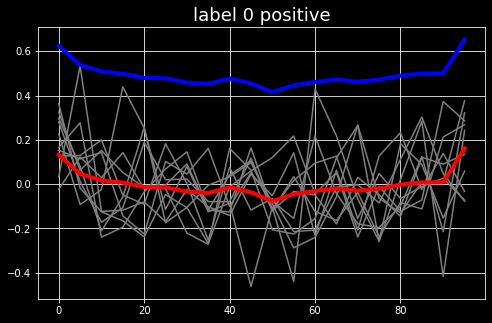

In [49]:
plt.figure(figsize=(8,5))
plt.title("label 0 positive", fontsize=18)
plt.grid(True)
x_coor = np.arange(0, 100, 5)
print(x_coor.shape)
count = 0
for i, label in enumerate(dbs.labels_):
    if label == 0:
        count+=1
        plt.plot(x_coor, X_shift_interp[i],color='gray')
    if count >= 10:
        break
y = np.array(y_sents)
plt.plot(x_coor, X_shift_interp[dbs.labels_==0].mean(axis=0),color='red', linewidth=4)
plt.plot(x_coor, X_interp[dbs.labels_==0].mean(axis=0),color='blue', linewidth=4)
plt.show()
print("percent of positive reviews", sum(y[dbs.labels_==0])/len(y[dbs.labels_==0]))

(20,)
percent of positive reviews 0.40540540540540543


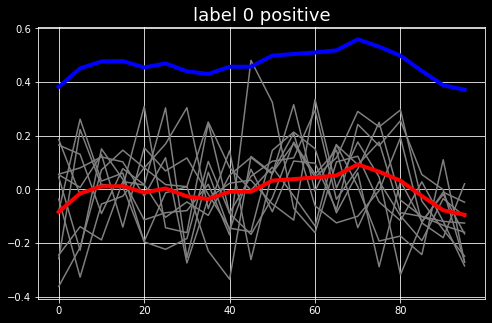

In [50]:
plt.figure(figsize=(8,5))
plt.title("label 0 positive", fontsize=18)
plt.grid(True)
x_coor = np.arange(0, 100, 5)
print(x_coor.shape)
count = 0
for i, label in enumerate(dbs.labels_):
    if label == 3:
        count+=1
        plt.plot(x_coor, X_shift_interp[i],color='gray')
    if count >= 10:
        break
y = np.array(y_sents)
plt.plot(x_coor, X_shift_interp[dbs.labels_==3].mean(axis=0),color='red', linewidth=4)
plt.plot(x_coor, X_interp[dbs.labels_==3].mean(axis=0),color='blue', linewidth=4)
plt.show()
print("percent of positive reviews", sum(y[dbs.labels_==3])/len(y[dbs.labels_==3]))

(20,)
percent of positive reviews 0.4289855072463768


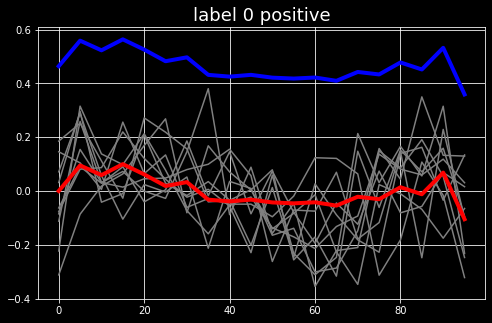

In [51]:
plt.figure(figsize=(8,5))
plt.title("label 0 positive", fontsize=18)
plt.grid(True)
x_coor = np.arange(0, 100, 5)
print(x_coor.shape)
count = 0
for i, label in enumerate(dbs.labels_):
    if label == 4:
        count+=1
        plt.plot(x_coor, X_shift_interp[i],color='gray')
    if count >= 10:
        break
y = np.array(y_sents)
plt.plot(x_coor, X_shift_interp[dbs.labels_==4].mean(axis=0),color='red', linewidth=4)
plt.plot(x_coor, X_interp[dbs.labels_==4].mean(axis=0),color='blue', linewidth=4)
plt.show()
print("percent of positive reviews", sum(y[dbs.labels_==4])/len(y[dbs.labels_==4]))